In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  

## Data Transformation
### Reading and Cleaning Dataset

In [98]:
# Load dataset and convert 'Date' column to datetime format
df = pd.read_csv('C:/Users/afeli/Desktop/Residual load - datasets/DATASET_final_untransformed_uncleaned.csv', sep=";")
df["Date"] = pd.to_datetime(df["Date"])

# Keep only the data from June 1, 2018, onwards, as the global radiation dataset starts from this date (reported by Celine)
df = df[df["Date"] >= '2018-06-18']

# Set 'Date' as the index for time-based operations
df.set_index("Date", inplace=True)

# Define valid value ranges for data cleaning
valid_ranges = {
    'Air_Temperature': (-90, 60),
    'Relative_Humidity': (0, 100),
    'Visibility': (0, 10),
    'Air_Pressure_at_Station_Height': (870, 1085),
    'Cloud_Cover': (0, 8),
    'Daily_Precipitation_Height': (0, np.inf),
    'Snow_Height_Daily_Value': (0, np.inf),
    'Global_Radiation': (0.1, np.inf),
    'Vapor_Pressure': (0, 70),
    'Dew_Point_Temperature': (-80, 30),
    'Wind_Direction': (0, 31),
    'Wind_Strength': (0, 12),
}

def clean_column(x, col_name):
    """Replace values outside the valid range with NaN."""
    min_val, max_val = valid_ranges.get(col_name, (None, None))
    return x.where((x >= min_val) & (x <= max_val), np.nan) if min_val is not None else x

# Apply cleaning function to all columns
for col in df.columns:
    df[col] = clean_column(df[col], col)

### Imputing Missing Values

In [99]:
from sklearn.experimental import enable_iterative_imputer  # This is necessary to enable IterativeImputer
from sklearn.impute import IterativeImputer

missing_before = df.isna().sum()

# Initialize IterativeImputer (MICE method)
imputer = IterativeImputer(max_iter=10, random_state=0)

# Impute missing values and convert back to DataFrame with original columns
df_imputed = pd.DataFrame(imputer.fit_transform(df), 
                                               columns=df.columns)

# Clip negative values to 0 for all columns after imputation, except 'Dew_Point_Temperature' and 'Air_Temperature', 
# as these columns can validly contain negative values (e.g., for temperatures below freezing).
columns_to_clip = df_imputed.columns.difference(['Dew_Point_Temperature', 'Air_Temperature'])

# Apply clipping for all columns except the ones in the exclusion list
df_imputed[columns_to_clip] = df_imputed[columns_to_clip].clip(lower=0)

# Restore the original index and update the original dataframe
df_imputed.index = df.index

missing_after = df_imputed.isna().sum()

# Output the before and after missing values for each column
missing_values_comparison = pd.DataFrame({
    'Before Imputation': missing_before,
    'After Imputation': missing_after
})

print(missing_values_comparison)

                                                   Before Imputation  \
Total (grid load) [MWh] Calculated resolutions                     0   
Residual load [MWh] Calculated resolutions                         0   
Hydro pumped storage [MWh] Calculated resolutions                  0   
Air_Temperature                                                   23   
Relative_Humidity                                                 23   
Visibility                                                        23   
Air_Pressure_at_Station_Height                                    19   
Cloud_Cover                                                       65   
Daily_Precipitation_Height                                         1   
Snow_Height_Daily_Value                                          558   
Global_Radiation                                                 287   
Vapor_Pressure                                                    23   
Dew_Point_Temperature                                           

## Exploratory Data Analysis

### Data Visualization

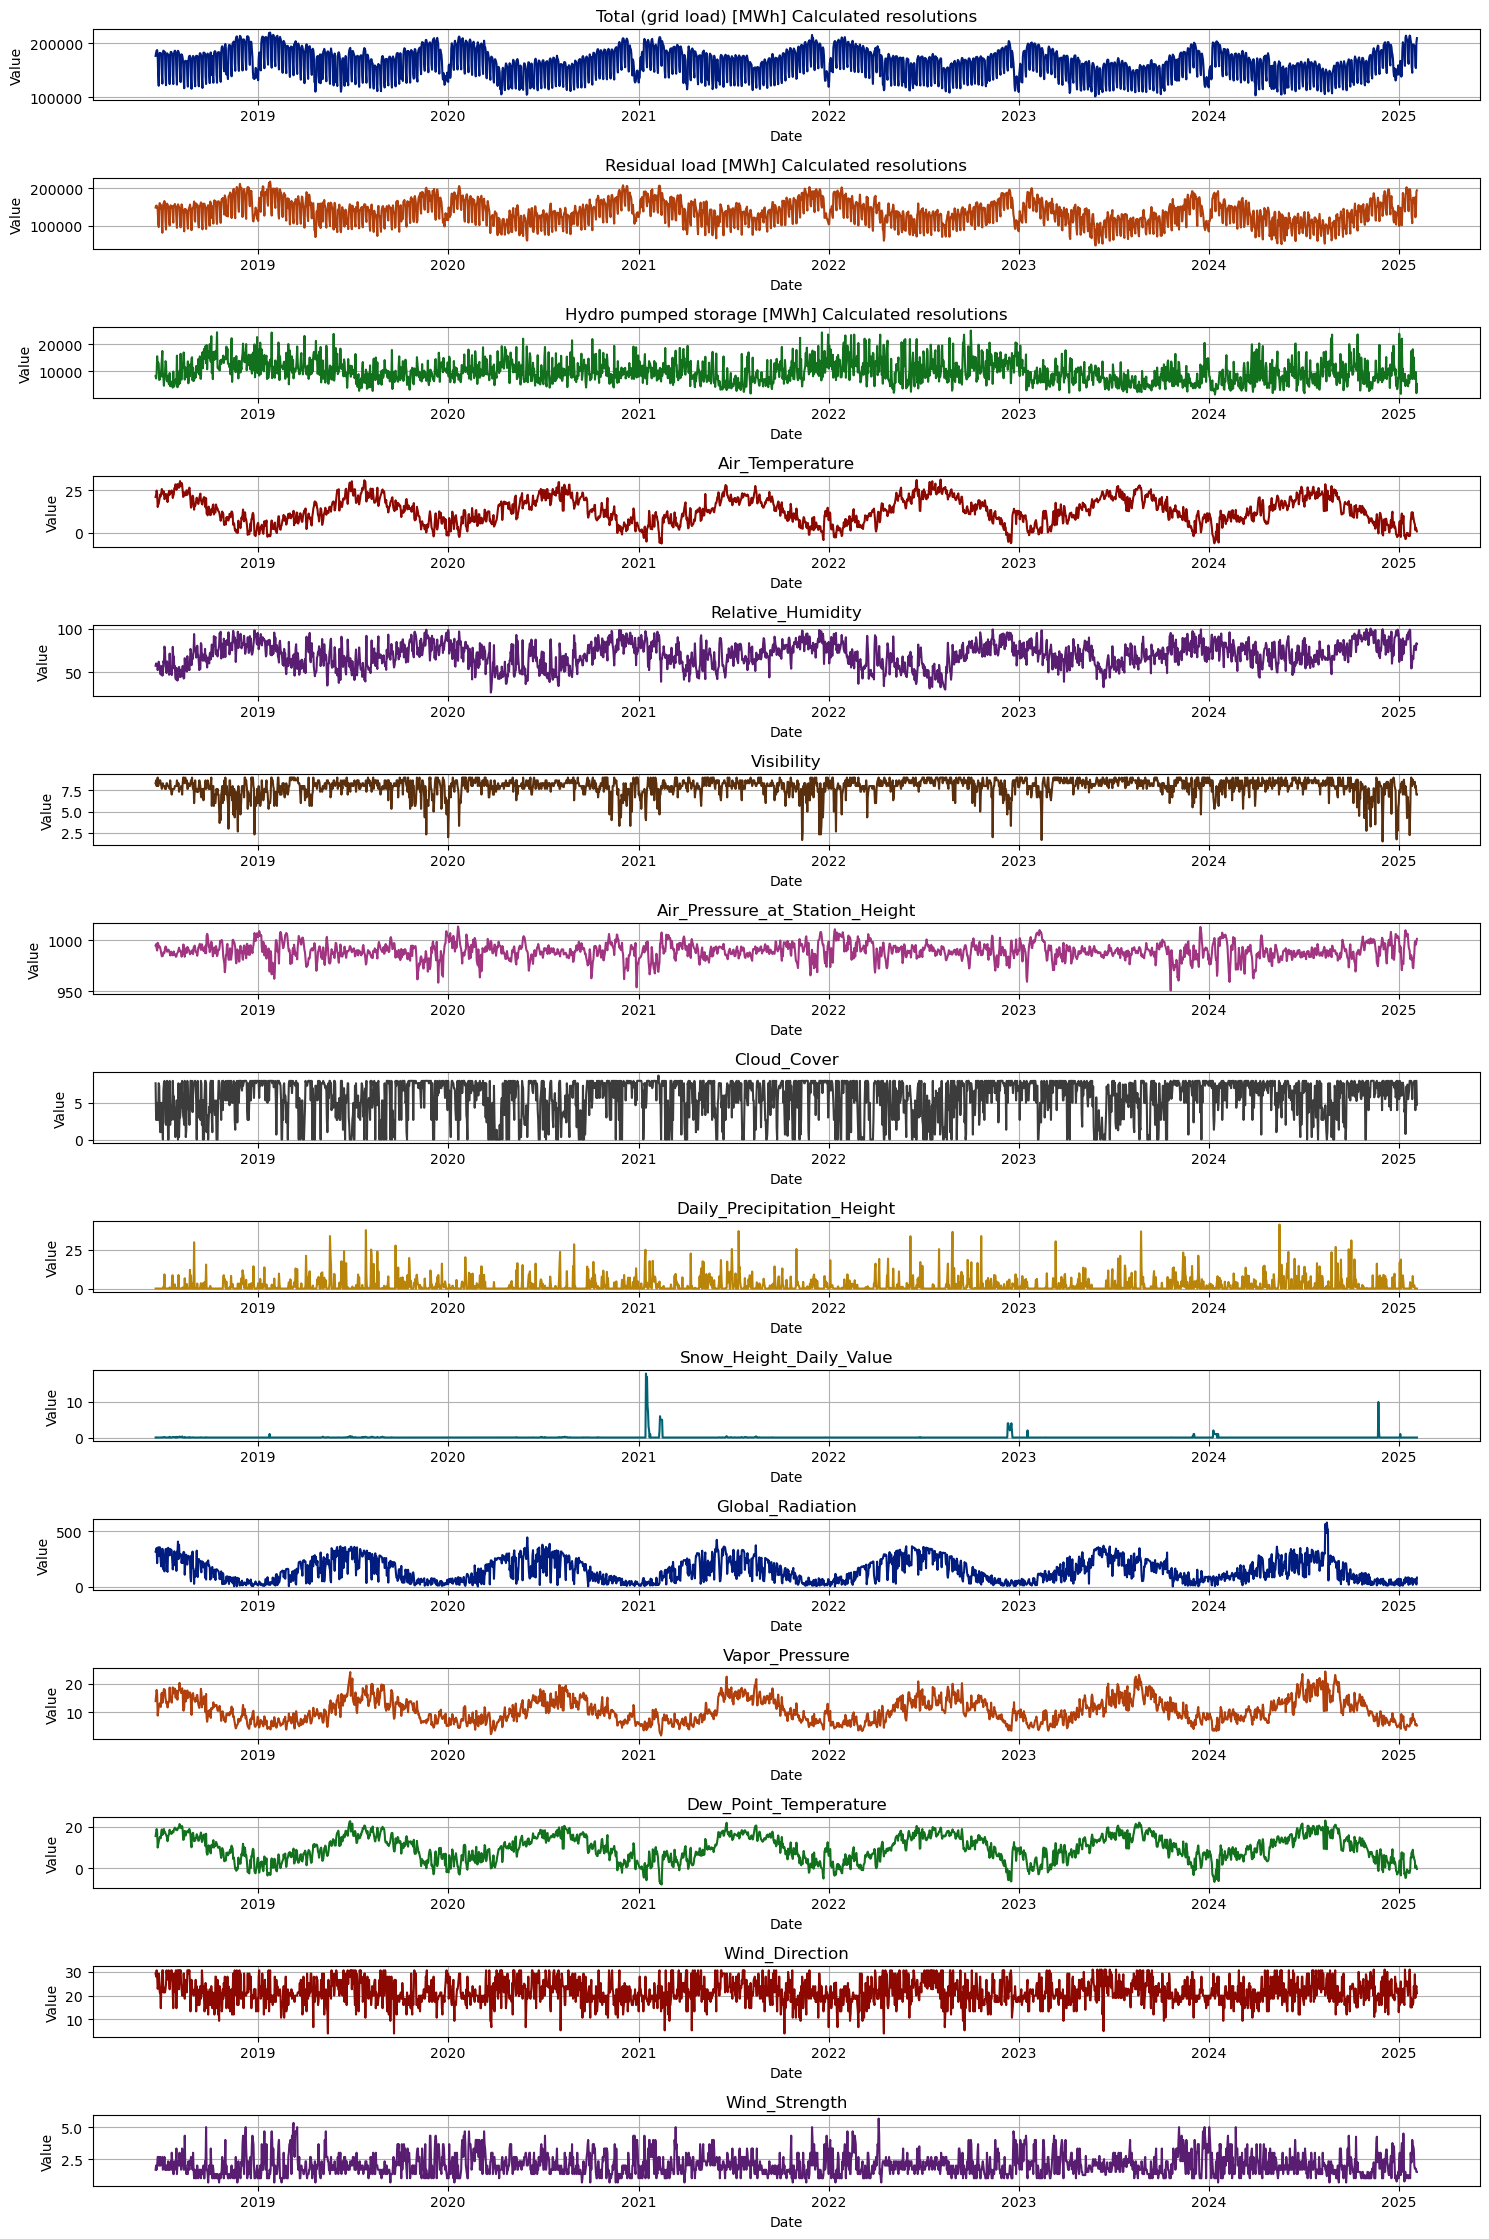

In [100]:
# # Set up the figure and axes
num_columns = len(df_imputed.columns)
fig, axes = plt.subplots(num_columns, 1, figsize=(num_columns, num_columns*1.5))  # Adjust figsize as needed

# # Define a color palette (you can adjust the palette)
palette = sns.color_palette("dark", n_colors=num_columns)

# # Loop through each column and plot it in the corresponding subplot with a different color
for i, column in enumerate(df_imputed.columns):
     sns.lineplot(data=df_imputed, x=df_imputed.index, y=column, ax=axes[i], color=palette[i])
     axes[i].set_title(column)
     axes[i].set_xlabel('Date')
     axes[i].set_ylabel('Value')
     axes[i].grid(True)

# # Adjust layout for better spacing
plt.tight_layout()

# # Show the plots
plt.show()

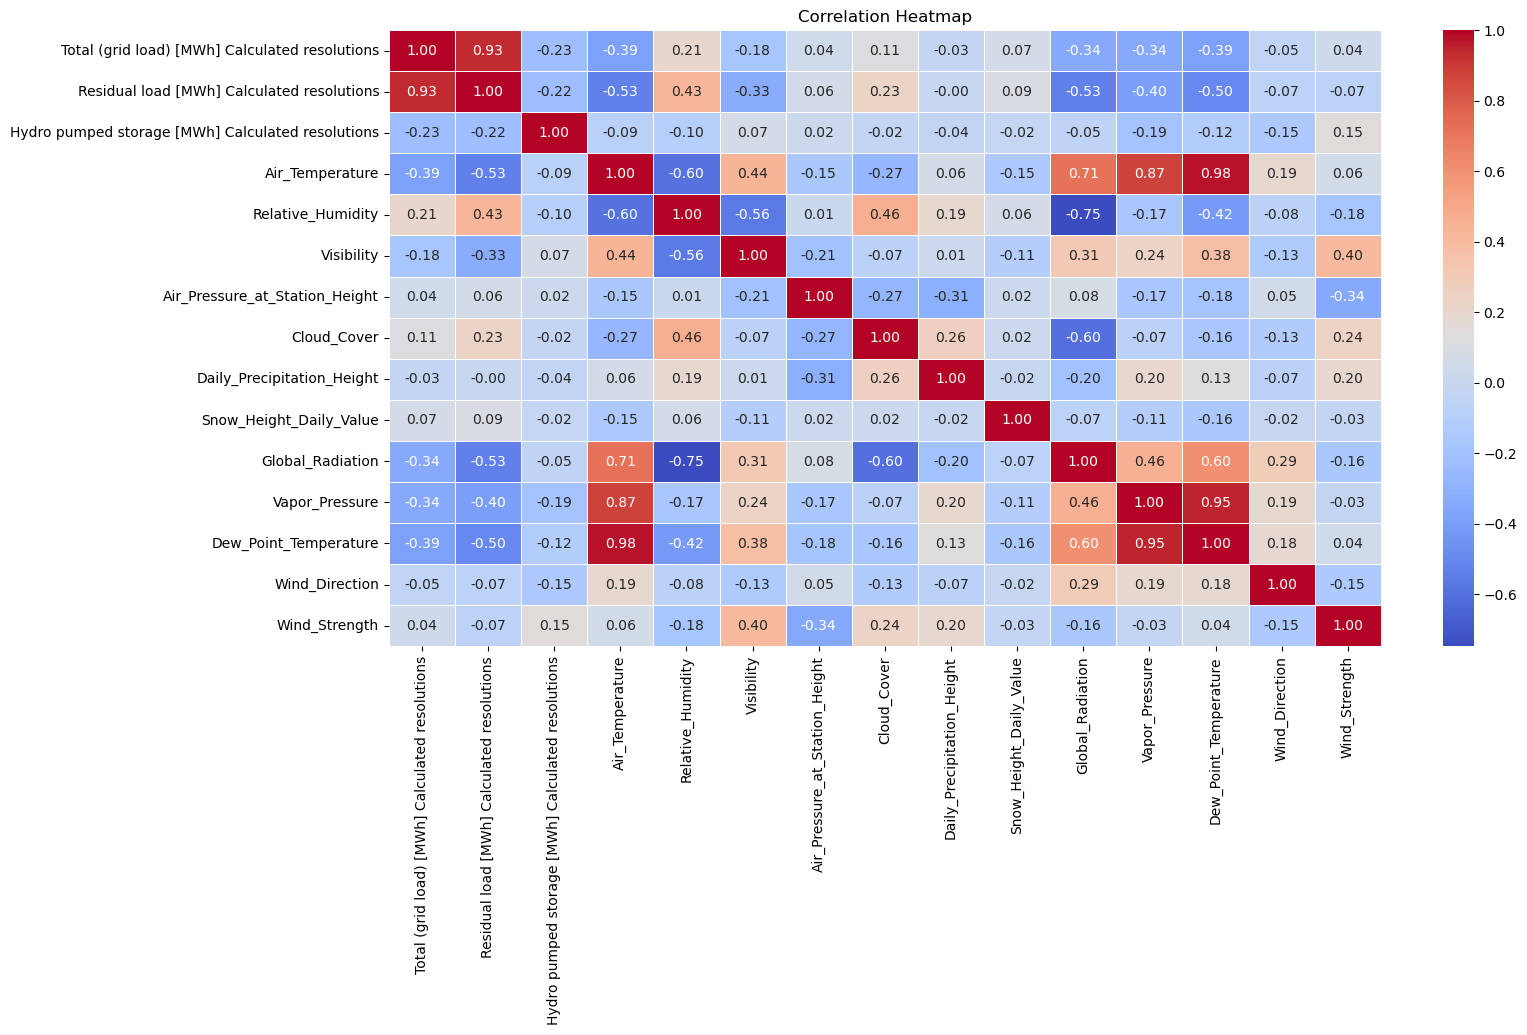

In [101]:
# # Set Date as the index for correlation
scale = 8
# # Create a correlation matrix
corr_matrix = df_imputed.corr()
plt.figure(figsize=(2*scale, 1*scale))
# # Create a heatmap to visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
             fmt=".2f", linewidths=0.5)

# # Show the plot
plt.title('Correlation Heatmap')
plt.show()

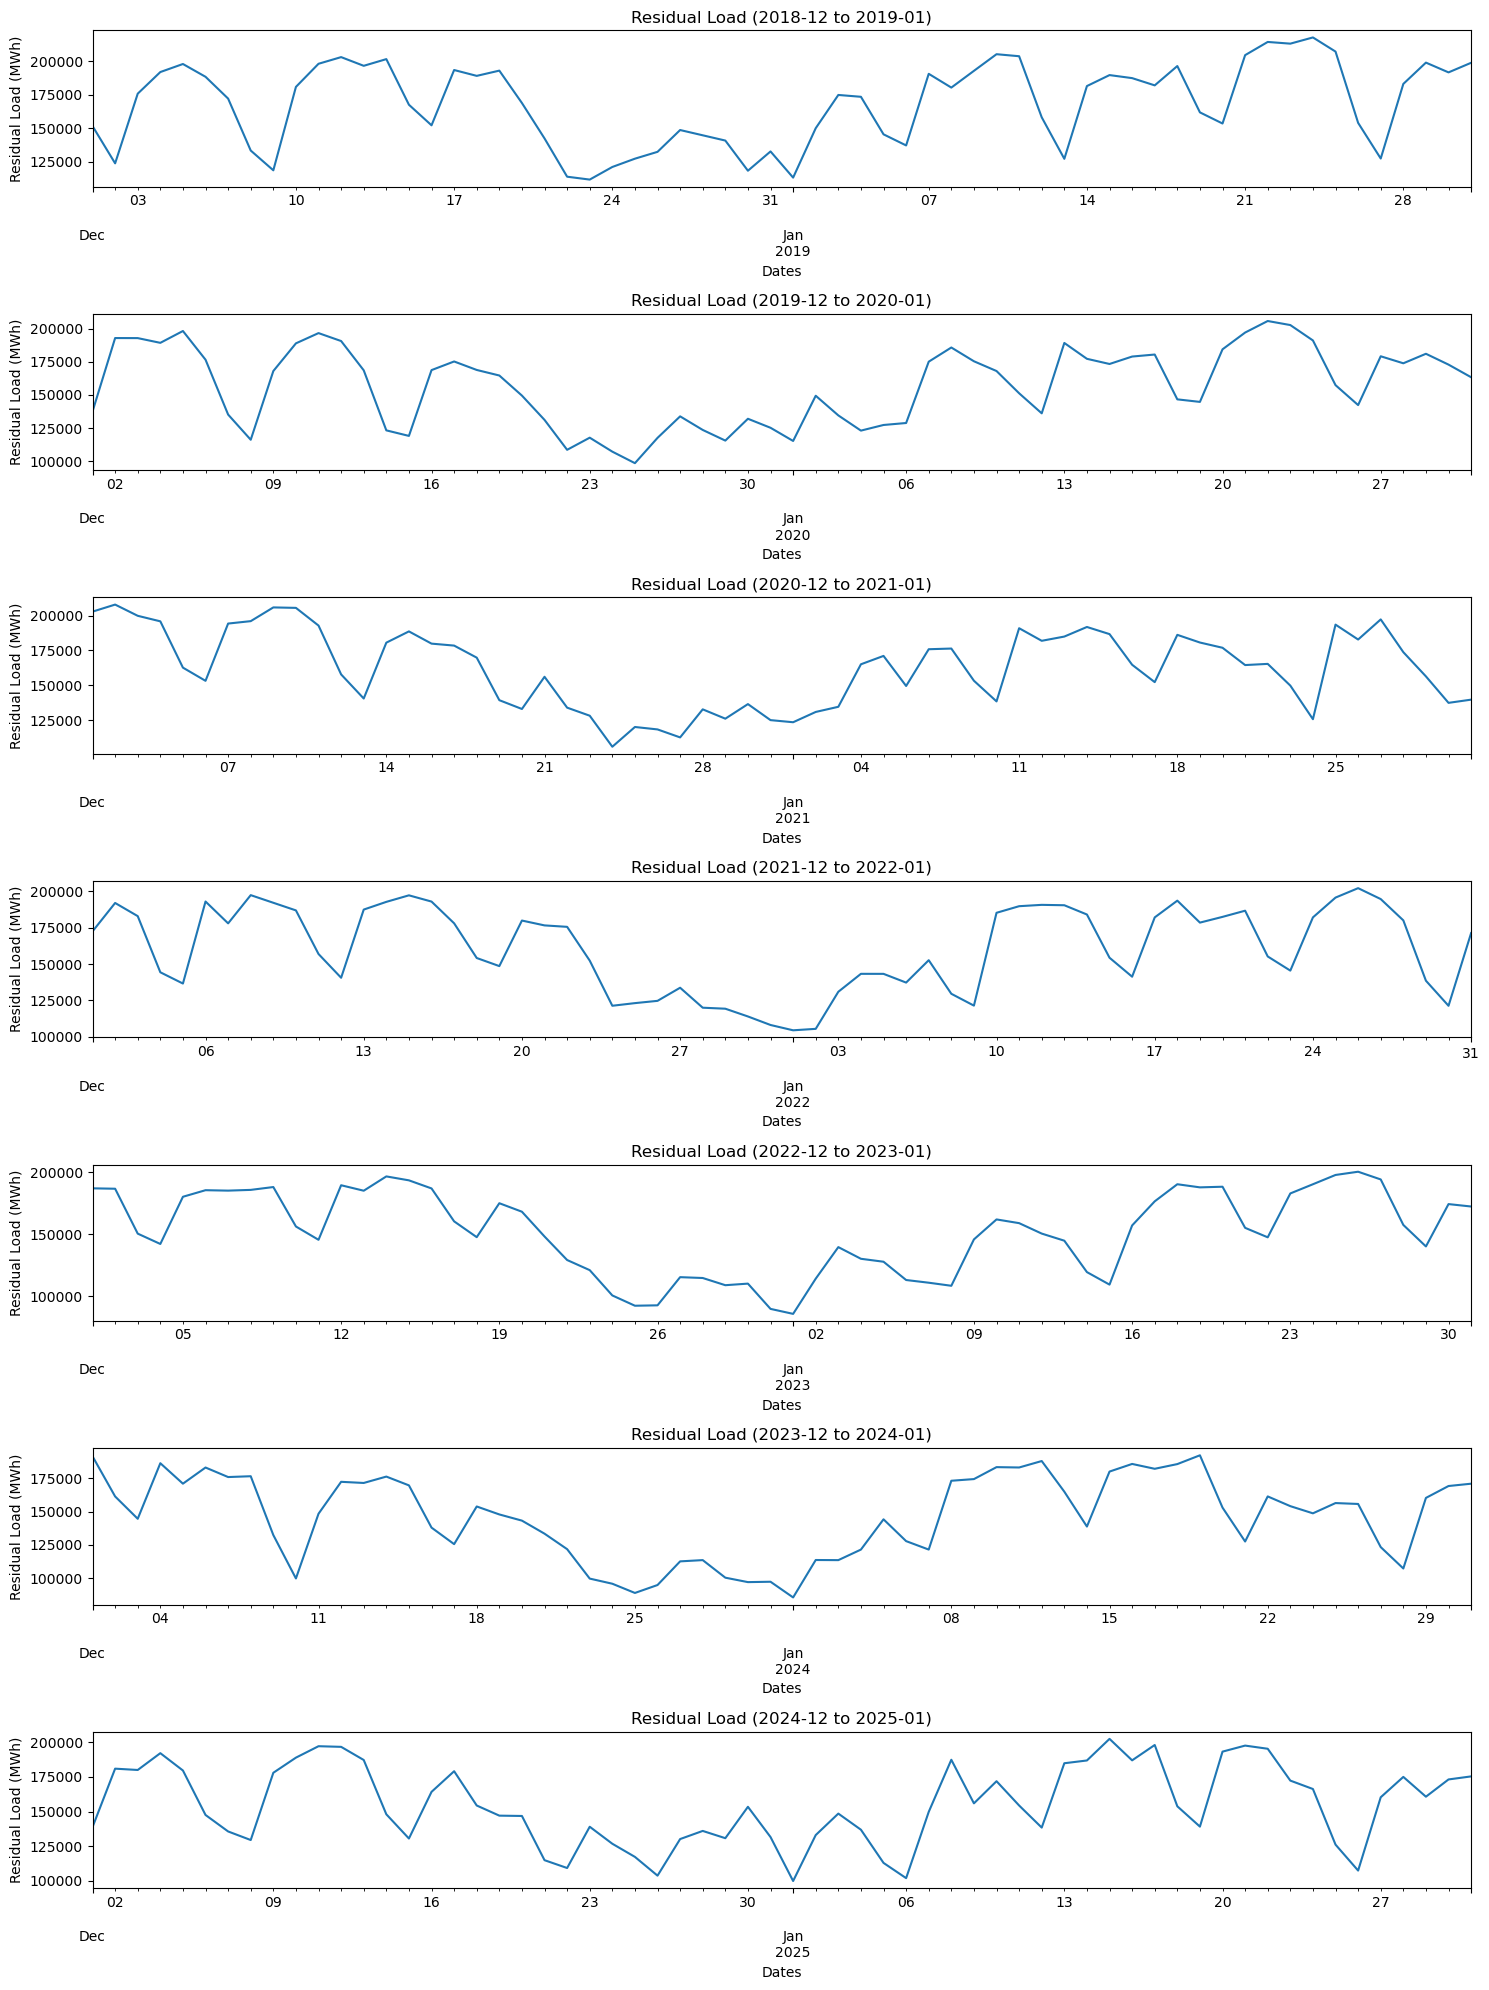

In [102]:
import matplotlib.pyplot as plt

# # Define the periods you want to plot
periods = [
     ("2018-12", "2019-01"),
     ("2019-12", "2020-01"),
     ("2020-12", "2021-01"),
     ("2021-12", "2022-01"),
     ("2022-12", "2023-01"),
     ("2023-12", "2024-01"),
     ("2024-12", "2025-01")
 ]

# # Create subplots (7 rows, 1 column, as you have 7 periods)
fig, ax = plt.subplots(len(periods), 1, figsize=(15, 20))

# # Loop through periods and plot each on a separate subplot
for i, (start_date, end_date) in enumerate(periods):
     df['Residual load [MWh] Calculated resolutions'][start_date:end_date].plot(
         kind='line', ax=ax[i], title=f"Residual Load ({start_date} to {end_date})"
     )
     ax[i].set_xlabel("Dates")
     ax[i].set_ylabel("Residual Load (MWh)")

# # Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Feature Engineering

### Feature Exploration

In [103]:
# Compute correlation matrix
corr_matrix = df_imputed.corr().abs()  # Use absolute values to check both positive & negative correlation

# Select upper triangle of correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find feature pairs with correlation above a threshold (e.g., 0.85)
threshold = 0.85
highly_correlated_pairs = []

for col in upper.columns:
    for row in upper.index:
        if upper.loc[row, col] > threshold:
            highly_correlated_pairs.append((row, col, upper.loc[row, col]))

# Convert to DataFrame for better readability
correlated_df = pd.DataFrame(highly_correlated_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
correlated_df = correlated_df.sort_values(by="Correlation", ascending=False)

# Display results
print("Highly Correlated Feature Pairs (Threshold > 0.85):")
display(correlated_df)

Highly Correlated Feature Pairs (Threshold > 0.85):


,Feature 1,Feature 2,Correlation
2,Air_Temperature,Dew_Point_Temperature,0.975497
3,Vapor_Pressure,Dew_Point_Temperature,0.947489
0,Total (grid load) [MWh] Calculated resolutions,Residual load [MWh] Calculated resolutions,0.933237
1,Air_Temperature,Vapor_Pressure,0.872194


### Adding Features (Month, Year, Holiday, etc.)

In [104]:
# Create a new dataframe to store the transformed data
df_transformed = df_imputed.copy()

# Add year, month, and day feature
df_transformed['dayofweek'] = df_transformed.index.dayofweek
df_transformed['quarter'] = df_transformed.index.quarter
df_transformed['month'] = df_transformed.index.month
df_transformed['year'] = df_transformed.index.year
df_transformed['dayofyear'] = df_transformed.index.dayofyear

def check_holiday(date):
    if (date.month == 12 and date.day == 24):  # Weihnachten (Christmas Eve)
        return 'Weihnachten'
    elif (date.month == 12 and date.day == 31):  # Silvester (New Year's Eve)
        return 'Silvester'
    else:
        return 'No_Holiday'

df_transformed['holiday'] = df_transformed.index.to_series().apply(check_holiday)
df_transformed['holiday'] = df_transformed['holiday'].astype("category")

# Removing Dew_Point_Temperature and Vapor_Pressure because of high correlation with air temperature and air temperature correlate more with the residual load
df_transformed = df_transformed.drop(["Dew_Point_Temperature", "Vapor_Pressure"], axis=1)

# Convert wind direction to radians for calculations
df_transformed['Wind_Direction_rad'] = np.deg2rad(df_transformed['Wind_Direction'])

# Calculate u and v components
df_transformed['wind_u'] = df_transformed['Wind_Strength'] * np.sin(df_transformed['Wind_Direction_rad'])
df_transformed['wind_v'] = df_transformed['Wind_Strength'] * np.cos(df_transformed['Wind_Direction_rad'])

# Drop some columns that is not needed
df_transformed = df_transformed.drop(columns=['Wind_Direction_rad', "Wind_Strength", 'Wind_Direction'], axis=1)

# Rename some columns
rename_dict = {
    'Total (grid load) [MWh] Calculated resolutions': 'Total_Load',
    'Residual load [MWh] Calculated resolutions': 'Residual_Load',
    'Hydro pumped storage [MWh] Calculated resolutions': 'Hydro_Pumped_Storage'
}
df_transformed.rename(columns=rename_dict, inplace=True)

## Combine Datasets (Electricity Generation & Weather Data)

In [108]:
trsnet_generation = pd.read_csv(
    "C:/Users/afeli/Desktop/Residual load - datasets/TransnetBW_electricity_actual_generation_day_150101_250320.csv",
    usecols=['Start date', 'Wind onshore [MWh] Calculated resolutions', 'Photovoltaics [MWh] Calculated resolutions'], delimiter=";",thousands=","  
)
trsnet_generation['Start date'] = pd.to_datetime(trsnet_generation['Start date'], format='%b %d, %Y')
trsnet_generation = trsnet_generation[trsnet_generation['Start date'] <= "2025-02-04"]
trsnet_generation.set_index('Start date', inplace=True)

# Ensure numeric data type for summation
trsnet_generation['Wind onshore [MWh] Calculated resolutions'] = trsnet_generation['Wind onshore [MWh] Calculated resolutions'].str.replace(',', '')
trsnet_generation['Wind onshore [MWh] Calculated resolutions'] = pd.to_numeric(trsnet_generation['Wind onshore [MWh] Calculated resolutions'], errors='coerce')
trsnet_generation['Photovoltaics [MWh] Calculated resolutions'] = trsnet_generation['Photovoltaics [MWh] Calculated resolutions'].str.replace(',', '')
trsnet_generation['Photovoltaics [MWh] Calculated resolutions'] = pd.to_numeric(trsnet_generation['Photovoltaics [MWh] Calculated resolutions'], errors='coerce')

trsnet_generation['electricity_generated'] = (
    trsnet_generation['Wind onshore [MWh] Calculated resolutions'] +
    trsnet_generation['Photovoltaics [MWh] Calculated resolutions']
)

trsnet_generation = trsnet_generation[['electricity_generated']]

In [109]:
df_transformed = df_transformed.join(trsnet_generation['electricity_generated'], how='left')

new_column_order = [
    'Total_Load', 'Residual_Load', 'electricity_generated',  # Electricity-related columns
    'Air_Temperature', 'Relative_Humidity', 'Visibility', 'Air_Pressure_at_Station_Height', 
    'Cloud_Cover', 'Daily_Precipitation_Height', 'Snow_Height_Daily_Value', 'Global_Radiation',  
    'wind_u', 'wind_v',  # Weather-related columns
    'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'holiday'  # Temporal features
]

df_transformed = df_transformed[new_column_order]

### Add Lag Features

In [110]:
target_map = df_transformed['Residual_Load'].to_dict()
df_transformed['Residual_Load_Tomorrow']= (df_transformed.index + pd.Timedelta(unit='days', value=1)).map(target_map)
df_transformed.dropna(inplace=True)
df_transformed.columns

Index(['Total_Load', 'Residual_Load', 'electricity_generated',
       'Air_Temperature', 'Relative_Humidity', 'Visibility',
       'Air_Pressure_at_Station_Height', 'Cloud_Cover',
       'Daily_Precipitation_Height', 'Snow_Height_Daily_Value',
       'Global_Radiation', 'wind_u', 'wind_v', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'holiday', 'Residual_Load_Tomorrow'],
      dtype='object')

## Model Training

### Function for Training XGBoost

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

def train_xgboost_model(X, y, enable_categorical=True, n_splits=5, n_estimators=500, learning_rate=0.05, 
                         max_depth=6, min_child_weight=5, subsample=0.8, colsample_bytree=0.8, gamma=0.1, 
                         early_stopping_rounds=20, random_state=42):
    """
    Train an XGBoost model with optimized hyperparameters and time-series cross-validation.
    
    Parameters:
    - X: Features (DataFrame)
    - y: Target variable (Series)
    - enable_categorical: Enables categorical support for XGBoost.
    - n_splits: Number of splits for TimeSeriesSplit.
    - n_estimators: Number of trees in the XGBoost model.
    - learning_rate: Step size for XGBoost model.
    - max_depth: Maximum depth of each tree.
    - min_child_weight: Minimum weight required to split a node.
    - subsample: Fraction of data used per boosting round.
    - colsample_bytree: Fraction of features used per tree.
    - gamma: Minimum loss reduction required to make a further partition.
    - early_stopping_rounds: Stops training if validation error doesn't improve.
    - random_state: Random seed for reproducibility.
    
    Returns:
    - avg_mae: Average Mean Absolute Error across all folds.
    - avg_rmse: Average Root Mean Squared Error across all folds.
    - avg_r2: Average R² Score across all folds.
    - avg_mape: Average Mean Absolute Percentage Error across all folds.
    - avg_smape: Average Symmetric MAPE across all folds.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)

    xgb_mae, xgb_rmse, xgb_r2, xgb_mape, xgb_smape = [], [], [], [], []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train XGBoost model with optimized hyperparameters
        xgb_model = XGBRegressor(
            enable_categorical=enable_categorical, 
            n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            random_state=random_state
        )
        
        xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=early_stopping_rounds, verbose=False)
        xgb_pred = xgb_model.predict(X_test)

        # Evaluate performance
        xgb_mae.append(mean_absolute_error(y_test, xgb_pred))
        xgb_rmse.append(np.sqrt(mean_squared_error(y_test, xgb_pred)))
        xgb_r2.append(r2_score(y_test, xgb_pred))

        mape = np.mean(np.abs((y_test - xgb_pred) / y_test)) * 100
        xgb_mape.append(mape)

        smape = np.mean(2 * np.abs(y_test - xgb_pred) / (np.abs(y_test) + np.abs(xgb_pred))) * 100
        xgb_smape.append(smape)

    # Calculate average scores
    avg_mae = np.mean(xgb_mae)
    avg_rmse = np.mean(xgb_rmse)
    avg_r2 = np.mean(xgb_r2)
    avg_mape = np.mean(xgb_mape)
    avg_smape = np.mean(xgb_smape)

    # Print results
    print("--- Optimized XGBoost Cross-Validation Results ---")
    print(f"Avg MAE: {avg_mae:.2f} (in MWh)")
    print(f"Avg RMSE: {avg_rmse:.2f} (in MWh)")
    print(f"Avg R² Score: {avg_r2:.2f}")
    print(f"Avg MAPE: {avg_mape:.2f} %")
    print(f"Avg SMAPE: {avg_smape:.2f} %")

    return avg_mae, avg_rmse, avg_r2, avg_mape, avg_smape, y_train, y_test, xgb_pred, xgb_model


In [138]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

def train_xgboost_model(X, y, enable_categorical=True, n_splits=5, n_estimators=800, learning_rate=0.03, 
                         max_depth=3, min_child_weight=5, subsample=0.5, colsample_bytree=0.5, gamma=0.5, 
                         random_state=42):
    """
    Train an XGBoost model with optimized hyperparameters and time-series cross-validation.
    
    Parameters:
    - X: Features (DataFrame)
    - y: Target variable (Series)
    - enable_categorical: Enables categorical support for XGBoost.
    - n_splits: Number of splits for TimeSeriesSplit.
    - n_estimators: Number of trees in the XGBoost model.
    - learning_rate: Step size for XGBoost model.
    - max_depth: Maximum depth of each tree.
    - min_child_weight: Minimum weight required to split a node.
    - subsample: Fraction of data used per boosting round.
    - colsample_bytree: Fraction of features used per tree.
    - gamma: Minimum loss reduction required to make a further partition.
    - early_stopping_rounds: Stops training if validation error doesn't improve.
    - random_state: Random seed for reproducibility.
    
    Returns:
    - avg_mae: Average Mean Absolute Error across all folds.
    - avg_rmse: Average Root Mean Squared Error across all folds.
    - avg_r2: Average R² Score across all folds.
    - avg_mape: Average Mean Absolute Percentage Error across all folds.
   
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)

    xgb_mae, xgb_rmse, xgb_r2, xgb_mape = [], [], [], []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train XGBoost model with optimized hyperparameters
        xgb_model = XGBRegressor(
            enable_categorical=enable_categorical, 
            n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            random_state=random_state
        )
        
        xgb_model.set_params(eval_metric="rmse")  # Before training, set eval_metric
            
        xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        xgb_pred = xgb_model.predict(X_test)        



        # Evaluate performance
    xgb_mae.append(mean_absolute_error(y_test, xgb_pred))
    xgb_rmse.append(np.sqrt(mean_squared_error(y_test, xgb_pred)))
    xgb_r2.append(r2_score(y_test, xgb_pred))

    mape = np.mean(np.abs((y_test - xgb_pred) / y_test)) * 100
    xgb_mape.append(mape)



    # Calculate average scores
    avg_mae = np.mean(xgb_mae)
    avg_rmse = np.mean(xgb_rmse)
    avg_r2 = np.mean(xgb_r2)
    avg_mape = np.mean(xgb_mape)
  

    # Print results
    print("--- Optimized XGBoost Cross-Validation Results ---")
    print(f"Avg MAE: {avg_mae:.2f} (in MWh)")
    print(f"Avg RMSE: {avg_rmse:.2f} (in MWh)")
    print(f"Avg R² Score: {avg_r2:.2f}")
    print(f"Avg MAPE: {avg_mape:.2f} %")
 

    return avg_mae, avg_rmse, avg_r2, avg_mape, y_train, y_test, xgb_pred, xgb_model

In [122]:
import xgboost
print(xgboost.__version__)

2.1.3


### Function for Plotting 

In [118]:
import matplotlib.dates as mdates

# Define the plotting function
def plot_predictions(y_train, y_test, xgb_pred, start_date, end_date):
    # Prepare the dataframes
    y_train_df = pd.DataFrame(y_train).rename(columns={y_train.name: 'y_train'})
    y_test_df = pd.DataFrame(y_test).rename(columns={y_test.name: 'y_test'})
    xgb_pred_df = pd.DataFrame(xgb_pred, index=y_test.index).rename(columns={0: 'xgb_pred'})

    # Merge them all into a single DataFrame
    combined_df = pd.concat([y_train_df, y_test_df, xgb_pred_df], axis=1)
    filtered_df = combined_df.loc[start_date:end_date]

    # Plotting the combined DataFrame
    plt.figure(figsize=(12, 6)) #Addjusted Size (Difference Original)

    plt.plot(filtered_df.index, filtered_df['y_train'], label='y_train', color='blue')
    plt.plot(filtered_df.index, filtered_df['y_test'], label='y_test', color='green')
    plt.plot(filtered_df.index, filtered_df['xgb_pred'], label='XGBoost Predicted', color='red')

    plt.title('True vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Residual Load')

    # # Format the x-axis to show daily ticks
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Set major ticks at daily intervals
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format date on x-axis

    plt.grid(True)
    plt.legend()

    plt.show()

## Train on Available Features All At Once

In [147]:
# Features and target
X = df_transformed.drop(columns=['Residual_Load_Tomorrow'])

y = df_transformed['Residual_Load_Tomorrow']

print(f"X columns are: {X.columns}\n")
print(f"y shape is: {y.name}")

X columns are: Index(['Total_Load', 'Residual_Load', 'electricity_generated',
       'Air_Temperature', 'Relative_Humidity', 'Visibility',
       'Air_Pressure_at_Station_Height', 'Cloud_Cover',
       'Daily_Precipitation_Height', 'Snow_Height_Daily_Value',
       'Global_Radiation', 'wind_u', 'wind_v', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'holiday'],
      dtype='object')

y shape is: Residual_Load_Tomorrow


In [146]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

xgb = XGBRegressor(enable_categorical=True)
random_search = RandomizedSearchCV(
    xgb, param_grid, cv=5, scoring="neg_mean_squared_error", n_iter=20, n_jobs=-1
)

tscv = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
random_search.fit(X_train, y_train)
print(random_search.best_params_)


{'subsample': 0.7, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.5}


In [136]:
param_grid = {
    "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "subsample": [0.5, 0.7, 1],
    "colsample_bytree": [0.5, 0.7, 1],
    "gamma": [0, 0.1, 0.5]
}

In [141]:
# Train, validate the model and extract relevant returned values
avg_mae, avg_rmse, avg_r2, avg_mape, y_train, y_test, xgb_pred, xgb_model = train_xgboost_model(X, y)

--- Optimized XGBoost Cross-Validation Results ---
Avg MAE: 10370.69 (in MWh)
Avg RMSE: 13258.43 (in MWh)
Avg R² Score: 0.84
Avg MAPE: 9.37 %


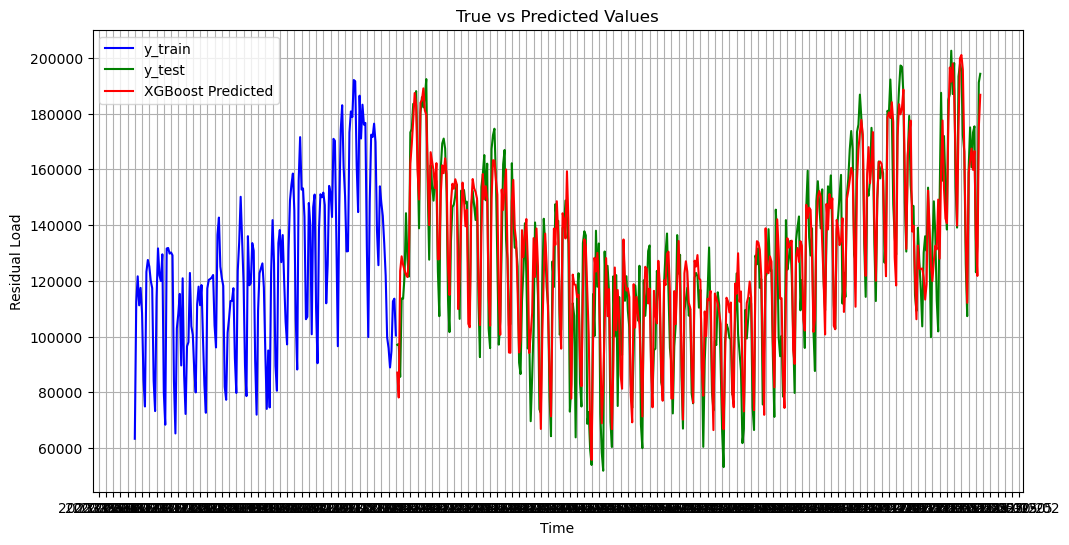

In [115]:
# Plotting prediction results
start_date = '2023-07-01'
end_date = y_test.index[-1]
plot_predictions(y_train, y_test, xgb_pred, start_date, end_date)

### Feature Importance

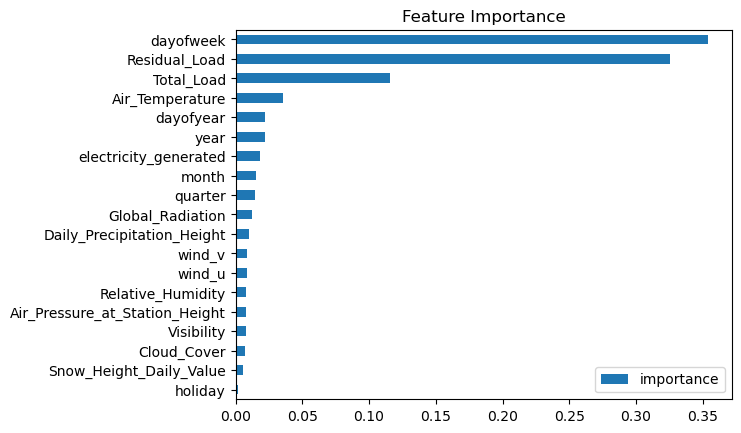

In [116]:
fi = pd.DataFrame(data=xgb_model.feature_importances_, index=xgb_model.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()